In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss, ConfusionMatrixDisplay

## **Loading the Dataset**

My first goal is to load the dataset and check for any missing values. As we can see below, there are no missing values in the dataset meaning that we will not have to employ any preprocessing methods to fill in the data. So we can proceed directly to our data exploration to understand how the features are behaving and brainstorm ideas for how we will modify and select our features for a multiclass logistic regression. 

In [4]:
path_to_file = "data/MNIST_train.csv"
digit_df = pd.read_csv(path_to_file)
digit_df.isna().sum().sum()

0

## **Data Exploration**

Because the MNIST dataset contains information regarding the pixels that encode images pertaining to handwritten digits, I first want to visualize a handful of these images to get an idea of how images of the same digit differ from one another. As we can see below, we have two instances of 0 and 1, however they are not identical images. The first image is clearly 1, however it is rotated sideways meaning that the information contained within its pixels will be quite different from the other image of 1 which is a more upright and centered image of the digit. This could be a potential cause for misclassification in our logistic regression, especially if two digits already look similar. For instance, a rotated 6 can look very similar to a rotated 9. Perhaps with other python libraries there are methods to rotate or recenter certain images however I did not employ such methods because this would be computationally intensive to perform on the entire dataset and would also require the use of external libraries that are outside the scope of the class thus far. Furthermore, I have the four subplots below to do some analysis on the dataset features themselves. We can see from the first histogram that we have a fairly balanced dataset, however further rebalancing at a later time may prove helpful to boost model performance. The other three subplots pertain to the feature variances as I want to visualize how different pixels are behaving in terms of there variance. The first graph depicts the variance of the pixels in numerical order. The fluctuations in the variances are what we expect to see as obviously more information pertaining to the digit will be contained in the pixels that are closer to the center of the image and the pixels closer to the edges will be much less useful for digit classification. Further, I created a density plot of the pixel variances and as we can see there are two distinct peaks. This means that many of the features either have small variance around 0 or have much higher variance around 12000. This is also supported by the final graph where I sorted the variances in descending fashion and created a line plot, which actually has a similar shape to the logistic function funnily enough. We can also infer from this graph that there are many pixels that have little to no variance. Overall, we can see from these graphs that it could be a good idea to drop the features with small variance when doing feature selection. This will not only decrease the dimension of our large dataset, but also hopefully improve the performance of our model. 

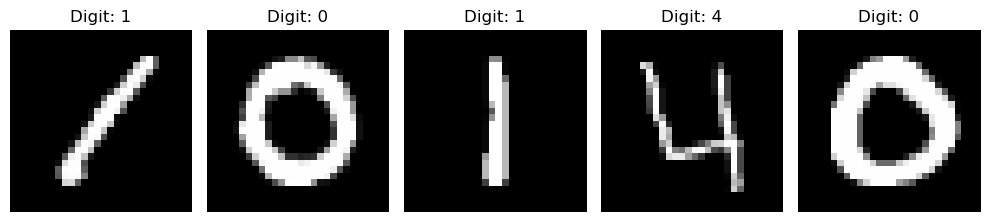

In [3]:
def digit_images():
    images = digit_df.drop('label', axis=1).head(25)
    labels = digit_df['label'].head(25) 
    plt.figure(figsize=(10,10))
    
    for k in range(5):
        plt.subplot(1,5, k+1)
        image = images.iloc[k].to_numpy().reshape(28,28)
        plt.imshow(image, cmap='gray')
        plt.title(f"Digit: {labels.iloc[k]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

digit_images()

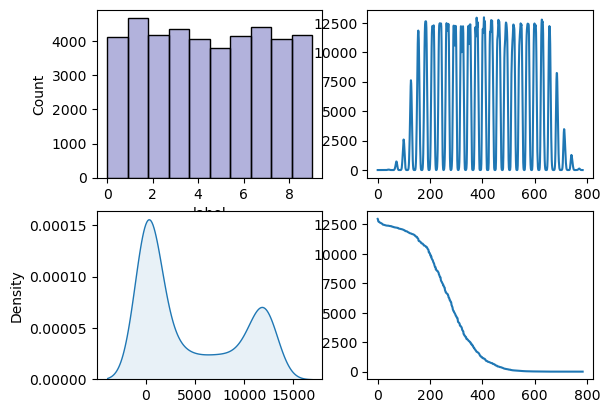

In [5]:
def data_exploration_plots():
    sorted_var = digit_df.drop(columns='label').agg('var').sort_values(ascending=False)
    fig, ax = plt.subplots(2, 2)
    plt.rcParams["figure.figsize"] = [7,5]
    plt.rcParams["figure.autolayout"] = True
    sns.histplot(digit_df, x= 'label', alpha=0.3, legend=True, bins=10, color='darkblue', ax=ax[0,0])
    sns.lineplot(x=np.arange(0, len(digit_df.iloc[:, 1:].var())), y=digit_df.iloc[:, 1:].var(), ax=ax[0,1])
    sns.kdeplot(data=digit_df.iloc[:, 1:].var(), ax=ax[1,0], fill=True, alpha=.1);
    sns.lineplot(x=np.arange(0, len(sorted_var)), y=sorted_var, ax=ax[1,1])

data_exploration_plots()

## **Building and Evaluating the Logistic Regression Model**

Now that I have done some preliminary data exploration and analysis it is time to build the core function of the project. The model validation function takes a few key parameters that we will manipulate to improve our model such as test size and class weight. Most importantly, I built the function so that I can choose whether or not to implement PCA and also specify the exact number of principal components I want to have. This will allow me to compare model performance with and without PCA as well as see how the model performs based on how many principal components I choose. So, the function will first take the feature and target vectors and split them into training and testing datsets. Then it will perform a k-fold cross validation with the specfied number of repeats to check if our model is overfitting. I will also rescale the datasets based on a scaler that is fit to the subtraining data as a general preprocessing step. This will help to reduce the impact of outliers on the model and is also an essential preliminary step should I choose to implement PCA. If PCA is true, the function will also train a PCA model that is fit to the subtraining data to avoid data leaking. A similar process is also used to train the final model for the training and testing data. To evaluate the performance of the model at each step, I will use the accuracy scores on both the training and testing datasets to get a general idea of how well the model is classifying the digits as well as a confusion matrix to visually see how well the model is performing on each label. However, the most important metric for evaluating the model performance is the log loss, which heavily penalizes the model if it predicts probabilities of digit labels that are different from the true probability of the label. Thus, a lower log loss value means that the model is predicting probabilities that are closer to the true label probabilities which indicates better model performance. So, when optimizing model performance I will mainly focus on minimizing the log loss while also trying to maintain a high accuracy score. 

In [6]:
def log_reg_model_validation(X, y, test_size=0.25, n_repeats = 50, class_weight = None, multi_class = 'multinomial', pca = False, n_pc = 20):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=12345)
    
    cv = RepeatedKFold(n_splits=5, n_repeats=n_repeats, random_state=12345)
    splitting = cv.split(X=X_train, y=y_train)

    kf_train_accuracies = []
    kf_test_accuracies = []
    kf_log_losses = []
    confusion_matrices = []

    for train_index, test_index in splitting:
        
        X_subtrain = X_train.iloc[train_index, :]
        X_subtest = X_train.iloc[test_index, :]
        y_subtrain = y_train.iloc[train_index, :]
        y_subtest = y_train.iloc[test_index, :]

        scaler = StandardScaler()
        scaler.fit(X_subtrain)
        X_subtrain = scaler.transform(X_subtrain)
        X_subtest = scaler.transform(X_subtest)
        
        if pca == True:
            pca_model = PCA(n_components=n_pc)
            pca_model.fit(X_subtrain) 
            X_subtrain = pca_model.transform(X_subtrain)
            X_subtest = pca_model.transform(X_subtest)

        logreg_model = LogisticRegression(max_iter=10000)
        logreg_model.fit(X=X_subtrain, y=y_subtrain.values.ravel())
        y_pred = logreg_model.predict(X_subtest)
        y_pred_prob = logreg_model.predict_proba(X_subtest)
        
        kf_train_accuracies.append(logreg_model.score(X=X_subtrain, y=y_subtrain))
        kf_test_accuracies.append(logreg_model.score(X=X_subtest, y=y_subtest))
        kf_log_losses.append(log_loss(y_true=y_subtest, y_pred=y_pred_prob))
        confusion_matrices.append(confusion_matrix(y_true=y_subtest, y_pred=y_pred))

    kf_train_accuracy = np.mean(kf_train_accuracies)
    kf_test_accuracy = np.mean(kf_test_accuracies)
    kf_log_loss = np.mean(kf_log_losses)
    kf_conf_matrix = np.mean(confusion_matrices, axis=0)

    print("K-Fold Cross Validation Performance")
    print(f"""k-fold train accuracy: {kf_train_accuracy}\nk-fold test accuracy: {kf_test_accuracy}\nk-fold log loss: {kf_log_loss}""")

    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    if pca == True:
        pca_model = PCA(n_components=n_pc)
        pca_model.fit(X_train) 
        X_train = pca_model.transform(X_train)
        X_test = pca_model.transform(X_test)
        
    logreg_model = LogisticRegression(max_iter=10000)
    logreg_model.fit(X=X_train, y=y_train.values.ravel())
    y_pred = logreg_model.predict(X_test)
    y_pred_prob = logreg_model.predict_proba(X_test)

    train_accuracy = logreg_model.score(X=X_train, y=y_train)
    test_accuracy = logreg_model.score(X=X_test, y=y_test)
    test_log_loss = log_loss(y_true=y_test, y_pred=y_pred_prob)
    conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,7))
    plt.rcParams["figure.autolayout"] = True
    fig.tight_layout()
    ConfusionMatrixDisplay(kf_conf_matrix).plot(ax=ax[0])
    ConfusionMatrixDisplay(conf_matrix).plot(ax=ax[1])
    ax[0].set_title("K-Fold Confusion Matrix")
    ax[1].set_title("Test Confusion Matrix")

    print("\nTesting Data Performance")
    print(f"""train accuracy: {train_accuracy}\ntest accuracy: {test_accuracy}\nlog loss: {test_log_loss}""")
    

## **Initial Model Performance**

Before attempting to use PCA and feature selection to improve the perfomance of the model I decided to evaulate the performance of the model that is trained on just the rescaled data without any other techniques to get a reliable baseline performance for future comparison. As we can see below, the model is already 90% accurate on the testing data without using any fancy techniques and the model does not appear to be overfitting as the testing accuracy is very close to the k-fold accuracy. However, when looking at the log loss we can see that although the model is fairly accurate, there are definetely discrepancies in the probabilities that the model is predicting compared to the true label probabilities. This is because we have a log loss of 0.477 on the testing data which is not necessarily as close to 0 as we ideally want. Furthermore, because we are working with a high dimension dataset it is very computationally intensive to run this model validation as we are training the model with all 784 features from the dataset. This means that while we have a decent initial model, there is certainly room for improvements in both performance and computational efficiency. 

K-Fold Cross Validation Performance
k-fold train accuracy: 0.9675515873015874
k-fold test accuracy: 0.8968222222222221
k-fold log loss: 0.5260408663363066

Testing Data Performance
train accuracy: 0.9602539682539682
test accuracy: 0.9035238095238095
log loss: 0.4777308417910606


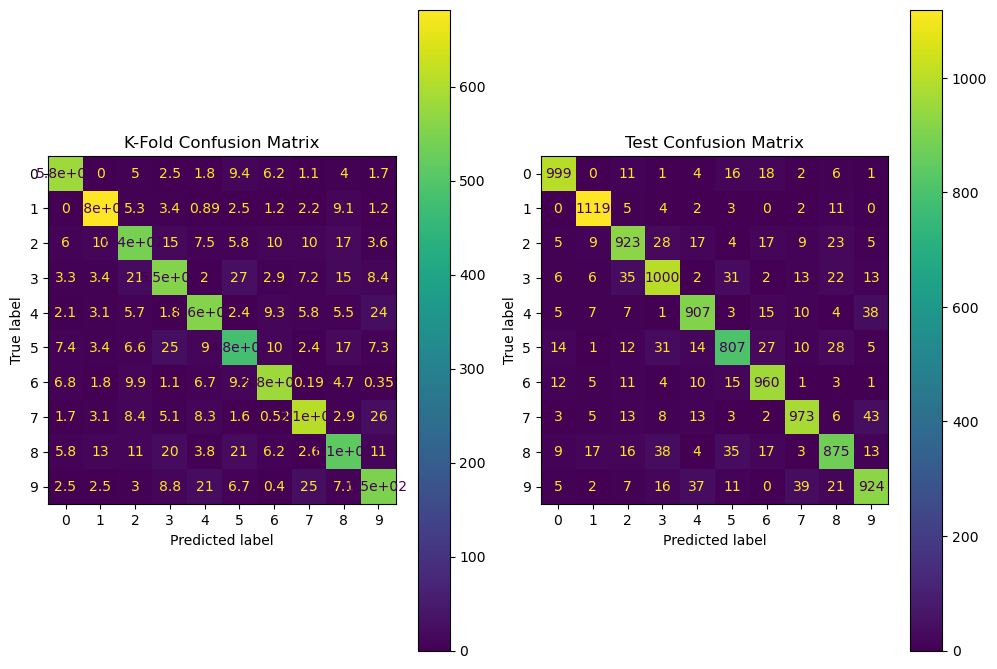

In [7]:
digit_df_pixels = digit_df.drop(columns='label')
X = digit_df_pixels
y = digit_df.loc[:, ['label']]
log_reg_model_validation(X, y, pca = False, n_repeats=20)

In [39]:
digit_df_pixels.shape[1]

784

## **Implementing PCA**

Now that I have a reliable baseline for model performance, I will attempt to improve the performance of the model. So, I will implement PCA to do this. Instead of simply guessing and checking which number of principal components is best, I will create an ROC curve of the log loss against the number of principal components to make an informed decision on the optimal number of principal components. To create the ROC curve I first built the 'get_log_loss' function which fits the model on the training data identically to how it is done in the model validation function but only returns the log loss. I will then use a for loop that will get the log loss of the model under an increasing number of principal components ranging from 5 to 200. I then append the log loss corresponding to each number of principal components to a list and create the ROC plot seen below. As we can see, the log loss certainly improves as we increase the number of principal components, however the curve flattens out fairly early. Thus the performance benefits seen by using more principal components starts to diminish after getting to around 75 principal components. Furthermore, we can see that the log loss of using 75 principal components is clearly lower the baseline log loss of 0.477. So, I implemented the model using 75 principal components based on my analysis of the ROC curve. As expected, the log loss drops all the way down to 0.308 which is a significant improvement in performance. The accuracy also increased to 0.91 which is also an improvement on the baseline model. I also found through some experimentation that decreasing the test size from 0.25 to 0.15 and changing class weight to 'balanced' also helps to boost the performance slightly. This is likely because by decreasing the test size we are increasing the amount of training data that we are fitting to our model. Also, the data is not perfectly balanced as seen in the data exploration. Thus, slight adjustments to the weights to ensure that we have balanced data will also help the performance of the model. Hence, by using PCA we have effectively improved the performance of our model. PCA also helps to reduce the dimension of the data that we are feeding into our model as we are transforming the 784 features into 75 principle components that will capture most of the variance from the original data. Although PCA does most of the feature selection for us, perhaps there is still some preliminary feature selection we can do to further improve the performance and efficiency of this PCA model. 

In [40]:
def get_log_loss(digit_df, n_pc, min_var, test_size=0.15, class_weight=None):
    digit_df_features = digit_df.drop(columns='label')
    X = digit_df_features.loc[:, (digit_df_features.var(axis=0) > min_var)]    
    y = digit_df.loc[:, ['label']]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=12345)
    
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    pca_model = PCA(n_components=n_pc)
    pca_model.fit(X_train) 
    X_train = pca_model.transform(X_train)
    X_test = pca_model.transform(X_test)

    logreg_model = LogisticRegression(max_iter=10000, class_weight=class_weight)
    logreg_model.fit(X=X_train, y=y_train.values.ravel())
    y_pred_prob = logreg_model.predict_proba(X_test)
    loss = log_loss(y_true=y_test, y_pred=y_pred_prob)

    return loss

Text(0, 0.5, 'Log Loss')

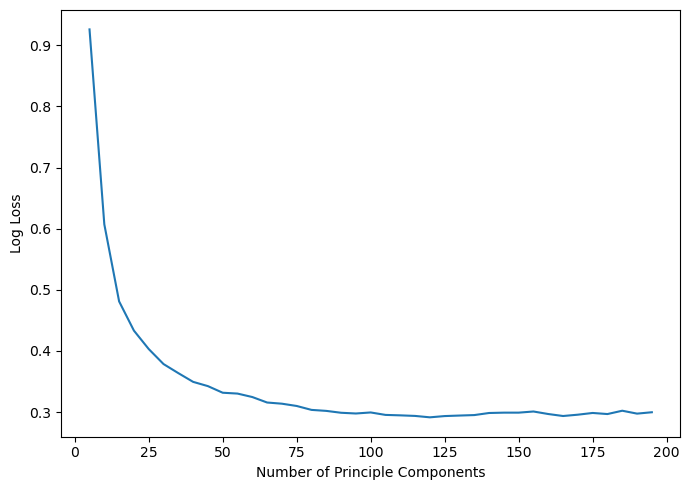

In [9]:
losses = []
for i in range(5,200,5):
    loss = get_log_loss(digit_df, n_pc=i, min_var=0, test_size=0.15)
    losses.append(loss)
fig = plt.figure()
plt.plot(np.arange(5,200,5), losses)
plt.xlabel('Number of Principle Components')
plt.ylabel('Log Loss')

K-Fold Cross Validation Performance
k-fold train accuracy: 0.9189030112044818
k-fold test accuracy: 0.9117591036414566
k-fold log loss: 0.32349628730457414

Testing Data Performance
train accuracy: 0.9174229691876751
test accuracy: 0.9133333333333333
log loss: 0.30896112765025857


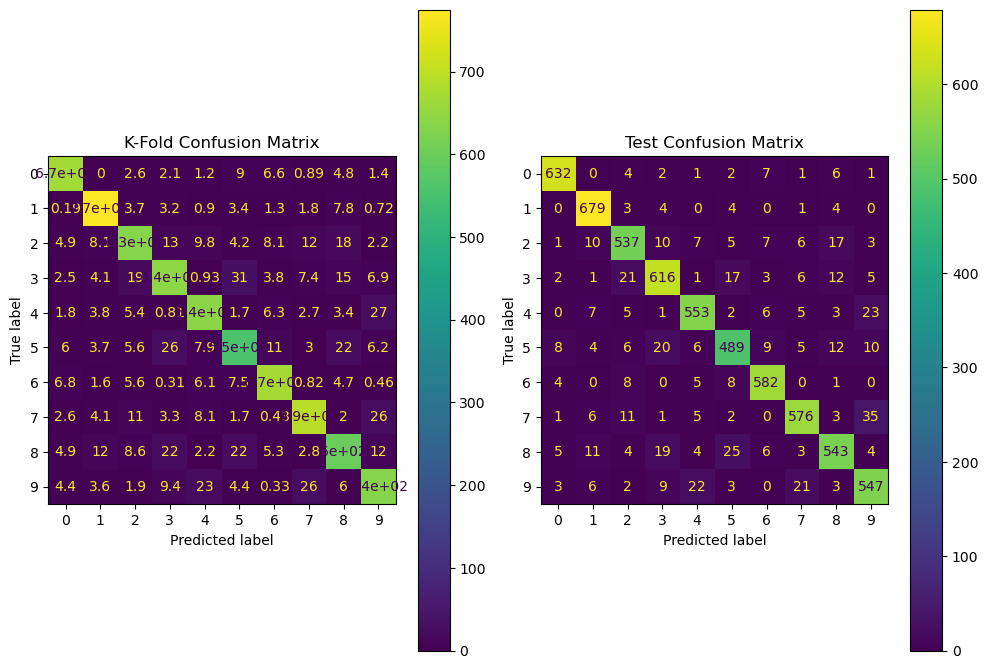

In [10]:
X = digit_df_pixels
y = digit_df.loc[:, ['label']]
log_reg_model_validation(X, y, pca = True, n_pc = 75, test_size=0.15, n_repeats=20, class_weight='balanced')

## **Selecting Features Based on Variance**

After improving the performance of the baseline model with PCA, I was still curious about further ways to boost performance. So, going back to the data exploration, I found that many features of the dataset have little or no variance meaning that these low variance features do not contain much useful information for label classification. So, to test my hypothesis that selecting features based on variance can boost performance I will create another ROC style plot that graphs the log loss against the minimum variance of the selected features. I also made sure to train the model with 75 principal components, a test size of 0.15, and balanced class weights to stay consistent with the improved model from above. So, I used a for loop similar to before and created the curve seen below. The log loss corresponding to a minimum pixel variance of 0 represents the performance of the initial PCA model. As we can see if we select our features based on a relatively small minimum variance that is greater then 0 we can indeed improve the log loss of our model. Because the loop is iterating at steps of 300 and the initial dip in log loss seems to be around 300, I decided to use this value as my minimum pixel variance. So, I selected features in the dataset with variance greater then 300 and trained the same PCA model as before for consistency. As we can see, this feature selection has further decreased the log loss to about 0.28 which is a fairly solid improvement on the previous model. Furthermore, we have slightly increased the accuracy from 0.913 to 0.916, which is not groundbreaking but certainly worth noting. Thus, this feature selection method has effectively improved the performance of our model. Furthermore, this feature selection has also significantly reduced the dimension of our features compared to the baseline model. In fact, after doing the feature selection we are using 480 features as opposed to the 784 features used in the baseline model. Thus, we have effectively cut out about 300 redundant features and simultaneously improved the performance of the model. When compared to the baseline model, we have seen significant improvements in the performance and reduced the dimension of the large dataset. We went from a log loss of 0.47 in the baseline model to a log loss of 0.28 in the final model, meaning that we are now seeing a 40% reduction in the baseline log loss! The accuracy also improved by about 1.5% which is a solid improvement, however we definetely care much more about the significant improvement in log loss. Overall, the model seen below improves upon the baseline model in terms of all the relevant metrics. 

Text(0, 0.5, 'Log Loss')

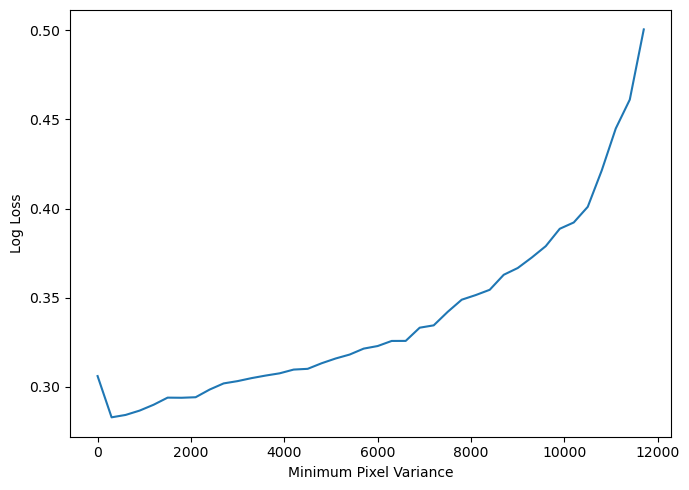

In [42]:
losses = []
for i in range(0,12000,300):
    loss = get_log_loss(digit_df, n_pc=75, min_var=i, test_size=0.15, class_weight='balanced')
    losses.append(loss)
fig = plt.figure()
plt.plot(np.arange(0,12000,300), losses)
plt.xlabel('Minimum Pixel Variance')
plt.ylabel('Log Loss')

K-Fold Cross Validation Performance
k-fold train accuracy: 0.9241008403361346
k-fold test accuracy: 0.9173543417366947
k-fold log loss: 0.2967491506908415

Testing Data Performance
train accuracy: 0.923249299719888
test accuracy: 0.916984126984127
log loss: 0.28380681025046317


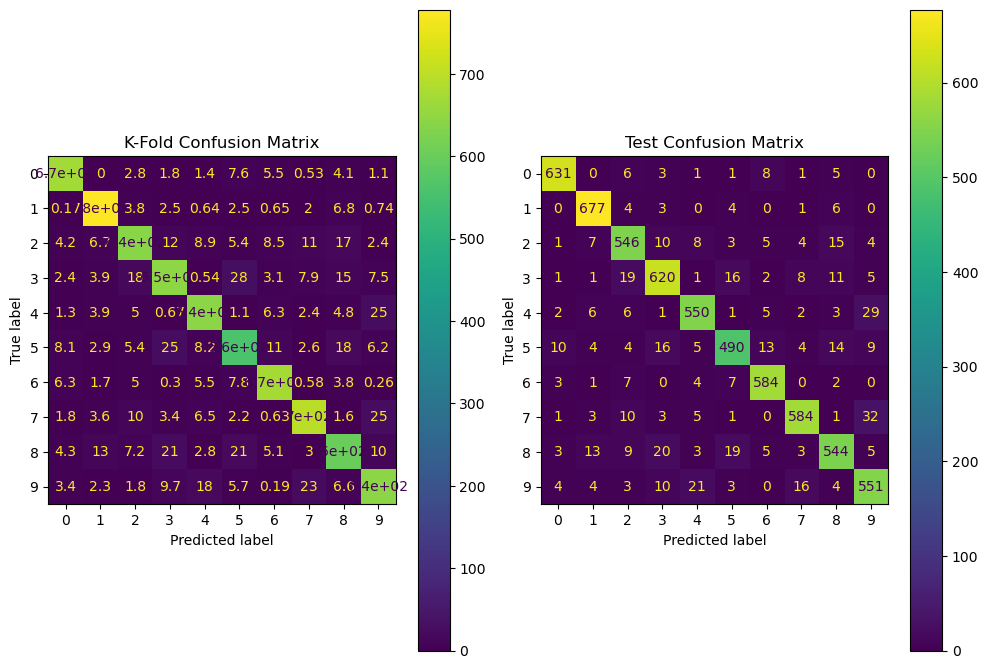

In [35]:
X = digit_df_pixels.loc[:, (digit_df_pixels.var(axis=0) > 300)]
y = digit_df.loc[:, ['label']]
log_reg_model_validation(X, y, pca = True, n_pc = 75, test_size=0.15, n_repeats=20, class_weight='balanced')

In [33]:
X.shape[1]

480